#DATA COLLECTION

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
pd.set_option('future.no_silent_downcasting', True)

In [ ]:
pip install fredapi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from fredapi import Fred

# --- Default Settings ---
DEFAULT_TICKER = "RELIANCE.NS"
DEFAULT_PERIOD = "5y"
SUGGESTED_TICKERS = [
    "RELIANCE.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS", "TCS.NS",
    "SBIN.NS", "LT.NS", "BHARTIARTL.NS", "ITC.NS", "ASIANPAINT.NS"
]
FRED_API_KEY = '//////////////////'  # Replace with your key

# --- Data Extraction Functions ---

# 1️⃣ Yahoo Finance Stock Prices
def generate_synthetic_stock_data(ticker=DEFAULT_TICKER, days=1260):
    dates = pd.date_range(end=datetime.today(), periods=days, freq='B')
    df = pd.DataFrame({
        'Date': dates,
        'Open': np.random.uniform(100, 200, size=days),
        'High': np.random.uniform(200, 300, size=days),
        'Low': np.random.uniform(50, 100, size=days),
        'Close': np.random.uniform(100, 200, size=days),
        'Adj Close': np.random.uniform(100, 200, size=days),
        'Volume': np.random.randint(1000000, 5000000, size=days),
        'Ticker': ticker
    })
    return df

def get_yfinance_data(ticker=DEFAULT_TICKER, period=DEFAULT_PERIOD, synthetic_days=1260):
    """Fetch stock data for a single ticker"""
    try:
        df = yf.download(ticker, period=period, progress=False, auto_adjust=False)
        if df.empty:
            raise ValueError("No data returned")
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        df = df.reset_index()
        required_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        for col in required_cols:
            if col not in df.columns:
                df[col] = np.nan
        df = df[required_cols]
        df['Ticker'] = ticker
        print(f"Yahoo Finance data fetched for {ticker}")
    except Exception as e:
        print(f"Yahoo Finance error for {ticker}: {e}. Generating synthetic data.")
        df = generate_synthetic_stock_data(ticker=ticker, days=synthetic_days)
    return df

# 2️⃣ SEC EDGAR Filings
def get_sec_edgar_filings(ticker=DEFAULT_TICKER, filings_per_ticker=5):
    form_types = ['10-K', '10-Q', '8-K', 'S-1', 'DEF 14A']
    mock_filings = []
    for i in range(filings_per_ticker):
        filing_date = datetime.today() - timedelta(days=np.random.randint(1, 365))
        form_type = np.random.choice(form_types)
        mock_filings.append({
            'Ticker': ticker,
            'FilingDate': filing_date,
            'FormType': form_type,
            'Title': f"{ticker} {form_type} Filing",
            'Summary': f"Summary of {form_type} filing for {ticker}.",
            'FilingLink': f"https://www.sec.gov/Archives/edgar/data/{ticker}/{i}",
            'Source': 'SEC EDGAR'
        })
    return pd.DataFrame(mock_filings)

# 3️⃣ Mock Kaggle-style Financial News
def get_kaggle_financial_news_mock(ticker= DEFAULT_TICKER, days=1825):
    """
    Generate mock financial news for multiple tickers.

    Args:
        tickers (list): List of ticker symbols to generate news for.
        days (int): Number of past days to generate news (default 2 years ~ 730 days).

    Returns:
        pd.DataFrame: Mock financial news dataset with columns ['Ticker', 'Date', 'Headline', 'Category']
    """
    news_data = []
    for ticker in ticker:
        for i in range(days):
            news_data.append({
                'Ticker': ticker,
                'Date': datetime.today() - timedelta(days=i),
                'Headline': f"Kaggle mock news {i+1} for {ticker}",
                'Category': np.random.choice(['Economy', 'Company', 'Market']),
            })
    return pd.DataFrame(news_data)


# 4️⃣ FRED Economic Data
def get_fred_economic_data(series_id, years=5):
    """Fetch economic data for the past N years from FRED API"""
    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date = (datetime.today() - pd.DateOffset(years=years)).strftime('%Y-%m-%d')

    try:
        fred = Fred(api_key=FRED_API_KEY)
        data = fred.get_series(series_id, start_date, end_date)
        df = pd.DataFrame(data, columns=[series_id])
        df['Date'] = df.index
        df.set_index('Date', inplace=True)
        print(f"FRED data fetched for {series_id} ({start_date} to {end_date})")
        return df
    except Exception as e:
        print(f"FRED API error for {series_id}: {e}")
        return pd.DataFrame()


# --- Execute Extraction Pipeline with SUGGESTED_TICKERS ---

# 1️⃣ Yahoo Finance for all suggested tickers
all_stock_data = [get_yfinance_data(ticker=t) for t in SUGGESTED_TICKERS]
combined_stock_df = pd.concat(all_stock_data, ignore_index=True)
print("=== Stock Data ===")
print(combined_stock_df.head())

# 2️⃣ SEC Filings for all suggested tickers
all_sec_filings = [get_sec_edgar_filings(ticker=t) for t in SUGGESTED_TICKERS]
sec_filings_df = pd.concat(all_sec_filings, ignore_index=True)
print("=== SEC Filings ===")
print(sec_filings_df.head())

# 3️⃣ Mock Kaggle News for all suggested tickers
all_news_data = [get_kaggle_financial_news_mock(ticker=t) for t in SUGGESTED_TICKERS]
mock_kaggle_news_df = pd.concat(all_news_data, ignore_index=True)
print("=== Kaggle News ===")
print(mock_kaggle_news_df.head())

# 4️⃣ FRED Economic Data
gdp_df = get_fred_economic_data('GDPC1')
unemployment_rate_df = get_fred_economic_data('UNRATE')
cpi_df = get_fred_economic_data('CPIAUCSL')

economic_df = gdp_df.join([unemployment_rate_df, cpi_df], how='outer')
economic_df = economic_df.sort_index().ffill().infer_objects(copy=False)
print("=== Economic Data ===")
print(economic_df.head())



Yahoo Finance data fetched for RELIANCE.NS
Yahoo Finance data fetched for HDFCBANK.NS
Yahoo Finance data fetched for ICICIBANK.NS
Yahoo Finance data fetched for INFY.NS
Yahoo Finance data fetched for TCS.NS
Yahoo Finance data fetched for SBIN.NS
Yahoo Finance data fetched for LT.NS
Yahoo Finance data fetched for BHARTIARTL.NS
Yahoo Finance data fetched for ITC.NS
Yahoo Finance data fetched for ASIANPAINT.NS
=== Stock Data ===
Price       Date         Open         High          Low        Close  \
0     2020-10-08  1042.528076  1046.681641  1025.498779  1033.413452   
1     2020-10-09  1031.452148  1039.759155  1023.191284  1030.736816   
2     2020-10-12  1031.452148  1041.028198  1027.414062  1032.398193   
3     2020-10-13  1029.421509  1054.873291  1027.229370  1052.542725   
4     2020-10-14  1051.712036  1063.295654  1046.912354  1055.680908   

Price    Adj Close    Volume       Ticker  
0      1015.345947  21077808  RELIANCE.NS  
1      1012.716003  18545499  RELIANCE.NS  
2    

#DATA MERGE

In [ ]:
# Ensure correct datatypes
combined_stock_df['Date'] = pd.to_datetime(combined_stock_df['Date'])
mock_kaggle_news_df['Date'] = pd.to_datetime(mock_kaggle_news_df['Date'])
combined_stock_df['Ticker'] = combined_stock_df['Ticker'].astype(str)
mock_kaggle_news_df['Ticker'] = mock_kaggle_news_df['Ticker'].astype(str)

# Aggregate news by Ticker + Date
daily_news_count = (
    mock_kaggle_news_df.groupby(['Ticker', 'Date'])
    .size()
    .reset_index(name='NewsCount')
)

# Merge stock with news
stock_news_df = pd.merge(
    combined_stock_df,
    daily_news_count,
    on=['Ticker', 'Date'],
    how='left'
)

# Fill NaNs in news
stock_news_df['NewsCount'] = stock_news_df['NewsCount'].fillna(0).astype(int)

print("✅ Step 1 done: Stock + News merged")
print(stock_news_df.head())


✅ Step 1 done: Stock + News merged
        Date         Open         High          Low        Close    Adj Close  \
0 2020-10-08  1042.528076  1046.681641  1025.498779  1033.413452  1015.345947   
1 2020-10-09  1031.452148  1039.759155  1023.191284  1030.736816  1012.716003   
2 2020-10-12  1031.452148  1041.028198  1027.414062  1032.398193  1014.348450   
3 2020-10-13  1029.421509  1054.873291  1027.229370  1052.542725  1034.140869   
4 2020-10-14  1051.712036  1063.295654  1046.912354  1055.680908  1037.224121   

     Volume       Ticker  NewsCount  
0  21077808  RELIANCE.NS          0  
1  18545499  RELIANCE.NS          0  
2  14226473  RELIANCE.NS          0  
3  23112012  RELIANCE.NS          0  
4  26742011  RELIANCE.NS          0  


In [ ]:
# Convert filing date
sec_filings_df['FilingDate'] = pd.to_datetime(sec_filings_df['FilingDate'])
sec_filings_df['Ticker'] = sec_filings_df['Ticker'].astype(str)

# Sort data for merge_asof
stock_news_sorted = stock_news_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
filings_sorted = sec_filings_df.sort_values(['Ticker', 'FilingDate']).reset_index(drop=True)

merged_slices = []
for ticker in stock_news_sorted['Ticker'].unique():
    stock_t = stock_news_sorted[stock_news_sorted['Ticker'] == ticker]
    filings_t = filings_sorted[filings_sorted['Ticker'] == ticker]

    if not filings_t.empty:
        merged = pd.merge_asof(
            stock_t.sort_values('Date'),
            filings_t.drop(columns=['Ticker'], errors='ignore').sort_values('FilingDate'),
            left_on='Date',
            right_on='FilingDate',
            direction='backward'
        )
    else:
        merged = stock_t.copy()
        merged['FilingDate'] = pd.NaT
        merged['FormType'] = np.nan
        merged['Title'] = np.nan
        merged['Summary'] = np.nan
        merged['FilingLink'] = np.nan
        merged['Source'] = np.nan

    merged['Ticker'] = ticker
    merged_slices.append(merged)

stock_news_filings_df = pd.concat(merged_slices, ignore_index=True)

print("✅ Step 2 done: Stock + News + Filings merged")
print(stock_news_filings_df.head())


✅ Step 2 done: Stock + News + Filings merged
        Date         Open         High          Low        Close    Adj Close  \
0 2020-10-08  2104.500000  2107.949951  2072.050049  2088.649902  1999.263306   
1 2020-10-09  2094.000000  2108.899902  2045.150024  2050.600098  1962.842163   
2 2020-10-12  2067.899902  2086.449951  2041.250000  2077.850098  1988.925903   
3 2020-10-13  2077.000000  2114.000000  2054.050049  2064.649902  1976.290894   
4 2020-10-14  2070.000000  2085.500000  2055.000000  2071.350098  1982.704224   

    Volume         Ticker  NewsCount FilingDate FormType Title Summary  \
0  1427493  ASIANPAINT.NS          0        NaT      NaN   NaN     NaN   
1  1636939  ASIANPAINT.NS          0        NaT      NaN   NaN     NaN   
2  2182836  ASIANPAINT.NS          0        NaT      NaN   NaN     NaN   
3  2619233  ASIANPAINT.NS          0        NaT      NaN   NaN     NaN   
4  1530471  ASIANPAINT.NS          0        NaT      NaN   NaN     NaN   

  FilingLink Source  
0

In [ ]:
# Reset index and ensure Date column
economic_df_sorted = economic_df.sort_index().ffill().reset_index().rename(columns={'index':'Date'})
economic_df_sorted['Date'] = pd.to_datetime(economic_df_sorted['Date'])

# Sort left dataframe
stock_news_filings_sorted = stock_news_filings_df.sort_values('Date').reset_index(drop=True)

# Merge using merge_asof
master_df = pd.merge_asof(
    stock_news_filings_sorted,
    economic_df_sorted,
    on='Date',
    direction='backward'
)

print("✅ Step 3 done: Added economic indicators")
print(master_df.head())
print("📊 Columns in master dataset:", master_df.columns.tolist())


✅ Step 3 done: Added economic indicators
        Date         Open         High          Low        Close    Adj Close  \
0 2020-10-08  2104.500000  2107.949951  2072.050049  2088.649902  1999.263306   
1 2020-10-08   590.000000   601.500000   581.674988   595.900024   564.421997   
2 2020-10-08   890.299988   894.000000   879.049988   881.049988   820.186890   
3 2020-10-08  1042.528076  1046.681641  1025.498779  1033.413452  1015.345947   
4 2020-10-08   385.000000   389.700012   382.649994   387.500000   374.785187   

     Volume         Ticker  NewsCount FilingDate FormType Title Summary  \
0   1427493  ASIANPAINT.NS          0        NaT      NaN   NaN     NaN   
1  35060674    HDFCBANK.NS          0        NaT      NaN   NaN     NaN   
2   3918217          LT.NS          0        NaT      NaN   NaN     NaN   
3  21077808    RELIANCE.NS          0        NaT      NaN   NaN     NaN   
4  21085500   ICICIBANK.NS          0        NaT      NaN   NaN     NaN   

  FilingLink Source  

In [ ]:
# Ensure correct datatypes
combined_stock_df['Date'] = pd.to_datetime(combined_stock_df['Date'])
mock_kaggle_news_df['Date'] = pd.to_datetime(mock_kaggle_news_df['Date'])
combined_stock_df['Ticker'] = combined_stock_df['Ticker'].astype(str)
mock_kaggle_news_df['Ticker'] = mock_kaggle_news_df['Ticker'].astype(str)

# Aggregate news by Ticker + Date
daily_news_count = (
    mock_kaggle_news_df.groupby(['Ticker', 'Date'])
    .size()
    .reset_index(name='NewsCount')
)

# Merge stock with news
stock_news_df = pd.merge(
    combined_stock_df,
    daily_news_count,
    on=['Ticker', 'Date'],
    how='left'
)

# Fill NaNs in news
stock_news_df['NewsCount'] = stock_news_df['NewsCount'].fillna(0).astype(int)

print("✅ Step 1 done: Stock + News merged")
print(stock_news_df.head())


✅ Step 1 done: Stock + News merged
        Date         Open         High          Low        Close    Adj Close  \
0 2020-10-08  1042.528076  1046.681641  1025.498779  1033.413452  1015.345947   
1 2020-10-09  1031.452148  1039.759155  1023.191284  1030.736816  1012.716003   
2 2020-10-12  1031.452148  1041.028198  1027.414062  1032.398193  1014.348450   
3 2020-10-13  1029.421509  1054.873291  1027.229370  1052.542725  1034.140869   
4 2020-10-14  1051.712036  1063.295654  1046.912354  1055.680908  1037.224121   

     Volume       Ticker  NewsCount  
0  21077808  RELIANCE.NS          0  
1  18545499  RELIANCE.NS          0  
2  14226473  RELIANCE.NS          0  
3  23112012  RELIANCE.NS          0  
4  26742011  RELIANCE.NS          0  


In [ ]:
# Define the path
save_path = "/content/drive/MyDrive/Masters_AI/7-NLP and GenAI/Project/master_investment_dataset.csv"

# Save the DataFrame
master_df.to_csv(save_path, index=False)

print(f"💾 master_df has been saved to '{save_path}'")


💾 master_df has been saved to '/content/drive/MyDrive/Masters_AI/7-NLP and GenAI/Project/master_investment_dataset.csv'


# DATA PRE-PROCESSING

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re


# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Masters_AI/7-NLP and GenAI/Project

/content/drive/MyDrive/Masters_AI/7-NLP and GenAI/Project


In [ ]:
#Read the dataset
df = pd.read_csv("master_investment_dataset.csv")

In [ ]:
#List of features in a dataset
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker',
       'NewsCount', 'FilingDate', 'FormType', 'Title', 'Summary', 'FilingLink',
       'Source', 'GDPC1', 'UNRATE', 'CPIAUCSL'],
      dtype='object')

In [ ]:
df.info(())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12400 entries, 0 to 12399
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        12400 non-null  object 
 1   Open        12400 non-null  float64
 2   High        12400 non-null  float64
 3   Low         12400 non-null  float64
 4   Close       12400 non-null  float64
 5   Adj Close   12400 non-null  float64
 6   Volume      12400 non-null  int64  
 7   Ticker      12400 non-null  object 
 8   NewsCount   12400 non-null  int64  
 9   FilingDate  1998 non-null   object 
 10  FormType    1998 non-null   object 
 11  Title       1998 non-null   object 
 12  Summary     1998 non-null   object 
 13  FilingLink  1998 non-null   object 
 14  Source      1998 non-null   object 
 15  GDPC1       12400 non-null  float64
 16  UNRATE      12400 non-null  float64
 17  CPIAUCSL    12400 non-null  float64
dtypes: float64(8), int64(2), object(8)
memory usage: 1.7+ MB


In [ ]:
df = df.rename(columns={
    "Source": "DataSource",
    "GDPC1": "RealGDP",
    "UNRATE": "UnemploymentRate",
    "CPIAUCSL": "ConsumerPriceIndex"
})

In [ ]:
#Check for null values in the datset
df.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Ticker,0
NewsCount,0
FilingDate,10402


In [ ]:
df_final = df.copy()

In [ ]:
#Total number rows = 12400 and total number of columns = 18
df_final.shape

(12400, 18)

In [ ]:
# Ensure FilingDate is datetime
df_final['FilingDate'] = pd.to_datetime(df_final['FilingDate'], errors='coerce')

# Sort by Ticker and Date
df_final = df_final.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# Forward-fill then backward-fill FilingDate **in-place**
df_final['FilingDate'] = df_final.groupby('Ticker')['FilingDate'].transform(lambda x: x.ffill().bfill())

# Add a flag for rows that originally had a filing
df_final['HasFiling'] = df_final['FilingDate'].notna().astype(int)

# Quick check
print(df_final[['Ticker', 'Date', 'FilingDate', 'HasFiling']].head(10))
print("Remaining NaT after ffill + bfill:", df_final['FilingDate'].isna().sum())


          Ticker        Date                 FilingDate  HasFiling
0  ASIANPAINT.NS  2020-10-08 2024-10-30 12:04:33.332125          1
1  ASIANPAINT.NS  2020-10-09 2024-10-30 12:04:33.332125          1
2  ASIANPAINT.NS  2020-10-12 2024-10-30 12:04:33.332125          1
3  ASIANPAINT.NS  2020-10-13 2024-10-30 12:04:33.332125          1
4  ASIANPAINT.NS  2020-10-14 2024-10-30 12:04:33.332125          1
5  ASIANPAINT.NS  2020-10-15 2024-10-30 12:04:33.332125          1
6  ASIANPAINT.NS  2020-10-16 2024-10-30 12:04:33.332125          1
7  ASIANPAINT.NS  2020-10-19 2024-10-30 12:04:33.332125          1
8  ASIANPAINT.NS  2020-10-20 2024-10-30 12:04:33.332125          1
9  ASIANPAINT.NS  2020-10-21 2024-10-30 12:04:33.332125          1
Remaining NaT after ffill + bfill: 0


In [ ]:
df_final['FormType'] = df_final['FormType'].fillna('Unknown')
df_final['Title'] = df_final['Title'].fillna('No Title')
df_final['Summary'] = df_final['Summary'].fillna('No Summary')
df_final['FilingLink'] = df_final['FilingLink'].fillna('No Link')
df_final['DataSource'] = df_final['DataSource'].fillna('Unknown')


In [ ]:
df_final.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Ticker,0
NewsCount,0
FilingDate,0


In [ ]:
# Convert FilingDate in SEC filings
df_final['FilingDate'] = pd.to_datetime(df_final['FilingDate'], errors='coerce')

# Convert Date in stock data
df_final['Date'] = pd.to_datetime(df_final['Date'], errors='coerce')

In [ ]:
# Find all duplicate rows
duplicate_rows = df_final[df_final.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
print(duplicate_rows)

Number of duplicate rows: 0
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume, Ticker, NewsCount, FilingDate, FormType, Title, Summary, FilingLink, DataSource, RealGDP, UnemploymentRate, ConsumerPriceIndex, HasFiling]
Index: []


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12400 entries, 0 to 12399
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                12400 non-null  datetime64[ns]
 1   Open                12400 non-null  float64       
 2   High                12400 non-null  float64       
 3   Low                 12400 non-null  float64       
 4   Close               12400 non-null  float64       
 5   Adj Close           12400 non-null  float64       
 6   Volume              12400 non-null  int64         
 7   Ticker              12400 non-null  object        
 8   NewsCount           12400 non-null  int64         
 9   FilingDate          12400 non-null  datetime64[ns]
 10  FormType            12400 non-null  object        
 11  Title               12400 non-null  object        
 12  Summary             12400 non-null  object        
 13  FilingLink          12400 non-null  object    

In [ ]:
# Convert to float first (coerce errors to NaN)
df_final['Open'] = pd.to_numeric(df_final['Open'], errors='coerce')
df_final['High'] = pd.to_numeric(df_final['High'], errors='coerce')
df_final['Low'] = pd.to_numeric(df_final['Low'], errors='coerce')
df_final['Close'] = pd.to_numeric(df_final['Close'], errors='coerce')
df_final['Adj Close'] = pd.to_numeric(df_final['Adj Close'], errors='coerce')
df_final['RealGDP'] = pd.to_numeric(df_final['RealGDP'], errors='coerce')
df_final['UnemploymentRate'] = pd.to_numeric(df_final['UnemploymentRate'], errors='coerce')
df_final['ConsumerPriceIndex'] = pd.to_numeric(df_final['ConsumerPriceIndex'], errors='coerce')

# Now format to 2 decimals (for prompt use)
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close',
                'RealGDP', 'UnemploymentRate', 'ConsumerPriceIndex']

for col in numeric_cols:
    df_final[col] = df_final[col].apply(lambda x: f"{x:.2f}" if pd.notnull(x) else "NaN")


In [ ]:
df_final.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker',
       'NewsCount', 'FilingDate', 'FormType', 'Title', 'Summary', 'FilingLink',
       'DataSource', 'RealGDP', 'UnemploymentRate', 'ConsumerPriceIndex',
       'HasFiling'],
      dtype='object')

In [ ]:
# --- Copy original dataframe ---
df2 = df_final.copy()

In [ ]:
type(df2)
df2.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker',
       'NewsCount', 'FilingDate', 'FormType', 'Title', 'Summary', 'FilingLink',
       'DataSource', 'RealGDP', 'UnemploymentRate', 'ConsumerPriceIndex',
       'HasFiling'],
      dtype='object')

# PROMPT CHAINING

In [ ]:
!pip install textblob

In [ ]:
from textblob import TextBlob

# ingestdata->pre-process->classify sentiment->summarize

In [ ]:
# -----------------------------
# 1️⃣ INGESTION: create PromptText from df2 columns
# -----------------------------
def ingest_prompt(row):
    """Creates natural-language prompt text from all relevant columns."""
    return (
        f"On {row['Date']}, ticker {row['Ticker']} opened at {row['Open']}, "
        f"closed at {row['Close']}. CPI: {row.get('ConsumerPriceIndex', 'N/A')}, "
        f"Unemployment Rate: {row.get('UnemploymentRate', 'N/A')}, GDP: {row.get('RealGDP', 'N/A')}."
    )

# -----------------------------
# 2️⃣ PREPROCESSING
# -----------------------------
def preprocess_prompt(text):
    """Basic text cleaning."""
    return str(text).strip().replace("  ", " ")

# -----------------------------
# 3️⃣ SENTIMENT ANALYSIS
# -----------------------------
BULLISH_KW = {"beat", "expansion", "tailwinds", "improved", "higher", "record", "gains", "growth", "arpu", "pli"}
BEARISH_KW = {"miss", "softness", "weak", "fine", "inquiry", "investigation", "headwind", "decline", "inflation"}

def compute_macro_thresholds(df):
    thresholds = {}
    for col in ['ConsumerPriceIndex', 'UnemploymentRate', 'RealGDP']:
        if col in df.columns:
            mean, std = df[col].mean(), df[col].std()
            thresholds[col] = {'low': mean - std, 'high': mean + std, 'mean': mean}
    return thresholds

def hybrid_sentiment(row, thresholds):
    """Compute sentiment using numeric columns and keywords in text."""
    score = 0

    # Price-based sentiment
    if row['Close'] > row['Open']:
        score += 1
    elif row['Close'] < row['Open']:
        score -= 1

    # Macro indicators
    for macro in ['ConsumerPriceIndex', 'UnemploymentRate', 'RealGDP']:
        if macro in row and macro in thresholds:
            if macro == 'RealGDP' and row[macro] > thresholds[macro]['high']:
                score += 1
            elif macro == 'RealGDP' and row[macro] < thresholds[macro]['low']:
                score -= 1
            elif macro != 'RealGDP' and row[macro] < thresholds[macro]['low']:
                score += 1
            elif macro != 'RealGDP' and row[macro] > thresholds[macro]['high']:
                score -= 1

    # Text-based keywords
    text = str(row['ProcessedText']).lower()
    bullish = sum(word in text for word in BULLISH_KW)
    bearish = sum(word in text for word in BEARISH_KW)
    score += bullish - bearish

    # Sentiment label
    if score > 0:
        return "positive"
    elif score < 0:
        return "negative"
    else:
        return "neutral"

# -----------------------------
# 4️⃣ SUMMARY GENERATION
# -----------------------------
def summary_prompt(row):
    """Generate structured summary with sentiment and tone."""
    tone = {
        "positive": "Market showed strength with improving indicators.",
        "negative": "Market sentiment was weak with adverse signals.",
        "neutral": "Market remained stable without strong directional bias."
    }
    return f"Summary: {row['ProcessedText']} Overall Sentiment: {row['Sentiment'].upper()}. {tone[row['Sentiment']]}"

# -----------------------------
# 5️⃣ MAIN PIPELINE
# -----------------------------
def run_pipeline(df2):
    # Ingest
    df2['PromptText'] = df2.apply(ingest_prompt, axis=1)

    # Preprocess
    df2['ProcessedText'] = df2['PromptText'].apply(preprocess_prompt)

    # Compute thresholds for numeric columns
    thresholds = compute_macro_thresholds(df2)

    # Sentiment classification
    df2['Sentiment'] = df2.apply(lambda row: hybrid_sentiment(row, thresholds), axis=1)

    # Generate structured summary
    df2['StructuredOutput'] = df2.apply(summary_prompt, axis=1)

    return df2

# -----------------------------
# 6️⃣ RUN PIPELINE ON YOUR df2
# -----------------------------

# Ensure numeric columns are properly typed
numeric_cols = ['ConsumerPriceIndex', 'UnemploymentRate', 'RealGDP', 'Open', 'Close', 'Adj Close', 'Volume', 'High']
for col in numeric_cols:
    df2[col] = pd.to_numeric(df2[col], errors='coerce')

df2 = run_pipeline(df2)

# View results
print(df2[['Ticker', 'Sentiment', 'StructuredOutput']])
#df2.drop(columns = ['ProcessedText'], inplace = True)


              Ticker Sentiment  \
0      ASIANPAINT.NS  negative   
1      ASIANPAINT.NS  negative   
2      ASIANPAINT.NS   neutral   
3      ASIANPAINT.NS  negative   
4      ASIANPAINT.NS   neutral   
...              ...       ...   
12395         TCS.NS   neutral   
12396         TCS.NS  negative   
12397         TCS.NS  positive   
12398         TCS.NS  negative   
12399         TCS.NS  positive   

                                        StructuredOutput  
0      Summary: On 2020-10-08 00:00:00, ticker ASIANP...  
1      Summary: On 2020-10-09 00:00:00, ticker ASIANP...  
2      Summary: On 2020-10-12 00:00:00, ticker ASIANP...  
3      Summary: On 2020-10-13 00:00:00, ticker ASIANP...  
4      Summary: On 2020-10-14 00:00:00, ticker ASIANP...  
...                                                  ...  
12395  Summary: On 2025-10-02 00:00:00, ticker TCS.NS...  
12396  Summary: On 2025-10-03 00:00:00, ticker TCS.NS...  
12397  Summary: On 2025-10-06 00:00:00, ticker TCS.NS...  
1

How sentiment is determined?

1 .Compare the stock's Close vs Open price:

Close > Open → score +1 (positive)

Close < Open → score -1 (negative)

Equal → score 0 (neutral)

Equal → score 0 (neutral)

2️. Macro Indicators

For each macro variable (CPI, Unemployment Rate, GDP), we compute thresholds based on the mean ± standard deviation of that column:

CPI

Below low threshold → +1

Above high threshold → -1

Unemployment Rate

Below low threshold → +1

Above high threshold → -1

GDP

Above high threshold → +1

Below low threshold → -1

This gives a market-condition-based signal.

3. Text Keyword Analysis

Scan the processed text for bullish keywords (like "growth", "gains", "improved") → add 1 per occurrence

Scan for bearish keywords (like "weak", "decline", "inflation") → subtract 1 per occurrence

This gives a textual sentiment signal from your filings/news.

Combine Scores

Total score = Price + Macro + Text score

Label sentiment:

Score > 0 → "positive"

Score < 0 → "negative"

Score = 0 → "neutral"

In short: hybrid approach combining price movement + macroeconomic conditions + text keywords to produce one sentiment label per row.

In [ ]:
# Extract sentiment from StructuredOutput
df2['Sentiment'] = df2['StructuredOutput'].str.extract(r'Sentiment:\s*(\w+)')

# Count occurrences
sentiment_counts = df2['Sentiment'].value_counts()

print(sentiment_counts)

Sentiment
NEGATIVE    5799
POSITIVE    4981
NEUTRAL     1620
Name: count, dtype: int64


In [ ]:
# -----------------------------
# 1️⃣ Earnings Agent Extraction
# -----------------------------
def earnings_agent_from_summary(summary_text: str):
    """Extract earnings signals based on keywords in structured summary."""
    summary_lower = summary_text.lower() if isinstance(summary_text, str) else ""
    eps_beat = 'strength' in summary_lower
    eps_miss = 'weak' in summary_lower
    stable = 'stable' in summary_lower
    return {"eps_beat": eps_beat, "eps_miss": eps_miss, "stable": stable}

# -----------------------------
# 2️⃣ Aggregate & Analyze Sentiment Trends
# -----------------------------
def aggregate_sentiment_trends(df):
    """Aggregate sentiment counts per ticker."""
    sentiment_counts = df.groupby('Ticker')['Sentiment'].value_counts().unstack(fill_value=0)
    return sentiment_counts

# -----------------------------
# 3️⃣ Prompt Chain Execution
# -----------------------------
def prompt_chain_execution(df, default_ticker='RELIANCE.NS'):
    # Normalize tickers
    df['Ticker'] = df['Ticker'].astype(str).str.strip().str.upper()

    # Step 1: Extract earnings signals
    df['EarningsSignals'] = df['StructuredOutput'].apply(earnings_agent_from_summary)

    # Step 2: Aggregate sentiment trends
    sentiment_trends = aggregate_sentiment_trends(df)

    # Step 3: Route to default ticker (show Reliance by default)
    df_default = df[df['Ticker'].str.contains(default_ticker.replace('.NS',''), case=False, na=False)]

    return df, sentiment_trends, df_default

# -----------------------------
# 4️⃣ Execute Pipeline
# -----------------------------
df2, sentiment_trends, df_reliance = prompt_chain_execution(df2)

# Example outputs
print("Aggregated Sentiment Trends per Ticker:\n", sentiment_trends)
print("\nEarnings Signals for Reliance.NS:\n", df_reliance[['Date','Ticker','EarningsSignals','Sentiment']])


Aggregated Sentiment Trends per Ticker:
 Sentiment      NEGATIVE  NEUTRAL  POSITIVE
Ticker                                    
ASIANPAINT.NS       609      161       470
BHARTIARTL.NS       600      151       489
HDFCBANK.NS         549      159       532
ICICIBANK.NS        554      169       517
INFY.NS             577      164       499
ITC.NS              599      155       486
LT.NS               575      175       490
RELIANCE.NS         573      151       516
SBIN.NS             577      174       489
TCS.NS              586      161       493

Earnings Signals for Reliance.NS:
            Date       Ticker  \
8680 2020-10-08  RELIANCE.NS   
8681 2020-10-09  RELIANCE.NS   
8682 2020-10-12  RELIANCE.NS   
8683 2020-10-13  RELIANCE.NS   
8684 2020-10-14  RELIANCE.NS   
...         ...          ...   
9915 2025-10-02  RELIANCE.NS   
9916 2025-10-03  RELIANCE.NS   
9917 2025-10-06  RELIANCE.NS   
9918 2025-10-07  RELIANCE.NS   
9919 2025-10-08  RELIANCE.NS   

                      

#Example plot(Reliance.NS)


📊 Processing: ASIANPAINT.NS
✅ Completed processing ASIANPAINT.NS

📊 Processing: HDFCBANK.NS
✅ Completed processing HDFCBANK.NS

📊 Processing: LT.NS
✅ Completed processing LT.NS

📊 Processing: RELIANCE.NS
📈 Showing plots for RELIANCE.NS


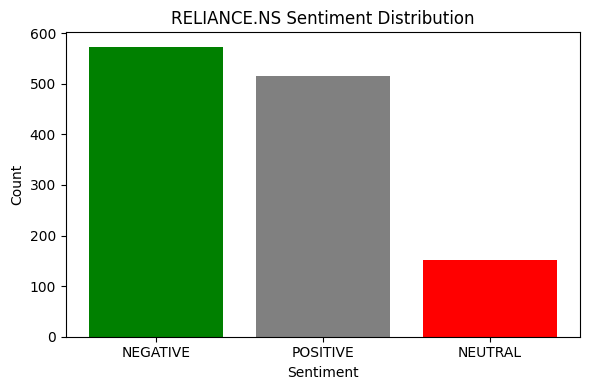

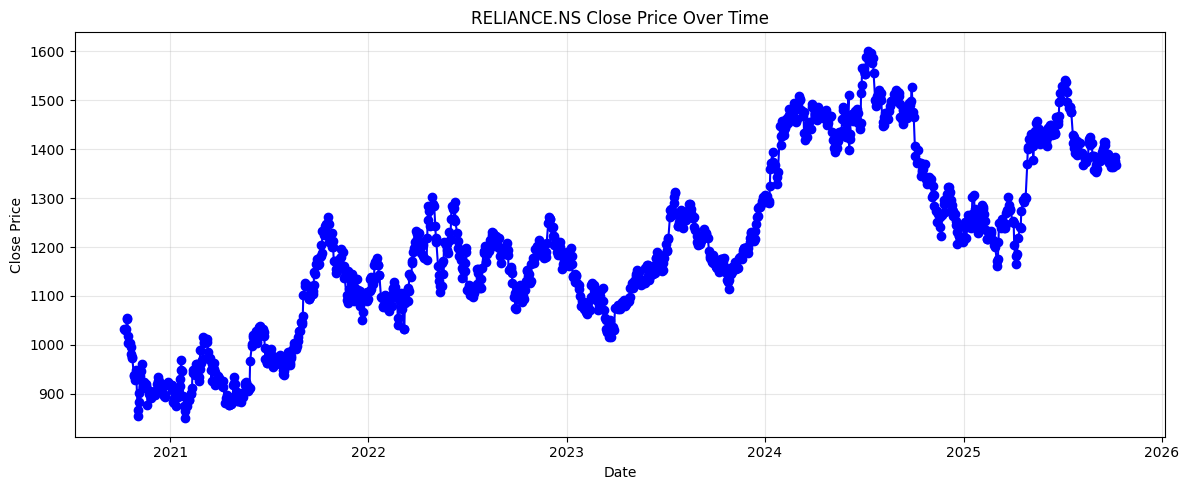

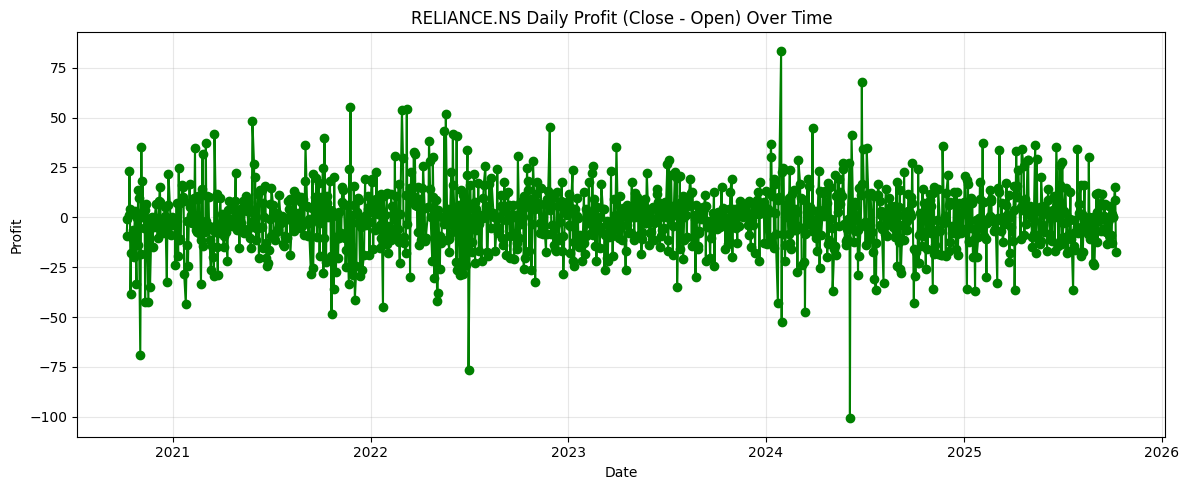

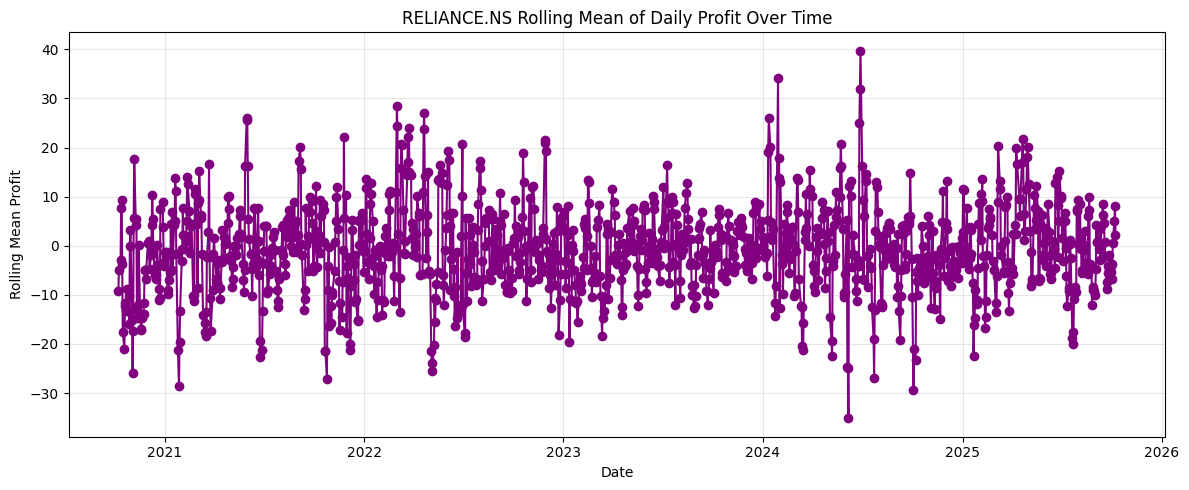

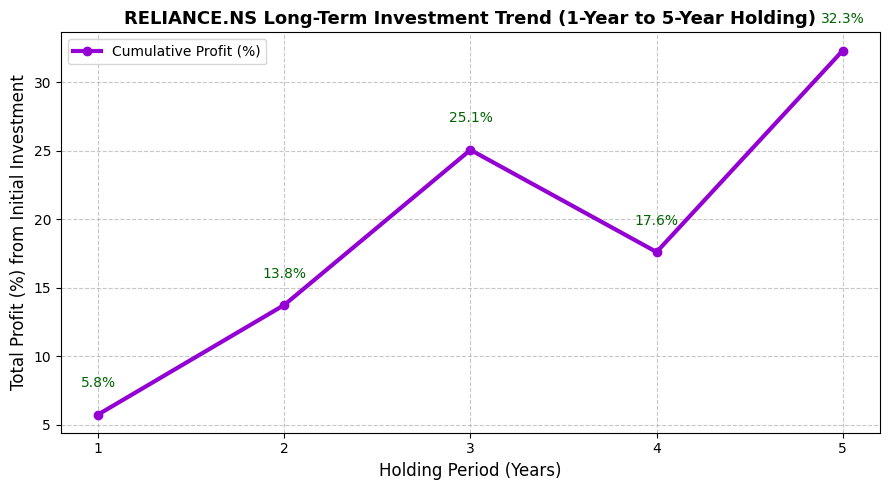

✅ Completed processing RELIANCE.NS

📊 Processing: ICICIBANK.NS
✅ Completed processing ICICIBANK.NS

📊 Processing: ITC.NS
✅ Completed processing ITC.NS

📊 Processing: SBIN.NS
✅ Completed processing SBIN.NS

📊 Processing: BHARTIARTL.NS
✅ Completed processing BHARTIARTL.NS

📊 Processing: INFY.NS
✅ Completed processing INFY.NS

📊 Processing: TCS.NS
✅ Completed processing TCS.NS


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_stock(df2, ticker='RELIANCE.NS'):
    """
    Analyze all tickers in df2 but show plots only for the specified ticker (default: RELIANCE.NS)
    """

    # Normalize for case-insensitive comparison
    ticker = ticker.strip().upper()

    # Get all unique tickers
    tickers = df2['Ticker'].unique() if 'Ticker' in df2.columns else [ticker]

    for t in tickers:
        print(f"\n📊 Processing: {t}")
        t_clean = str(t).strip().upper()

        # Filter for the current ticker
        df_t = df2[df2['Ticker'] == t].copy() if 'Ticker' in df2.columns else df2.copy()

        if df_t.empty:
            print(f"⚠️ Skipping {t} — no data available.")
            continue

        # Ensure Date column or use index
        if 'Date' in df_t.columns:
            df_t['Date'] = pd.to_datetime(df_t['Date'], errors='coerce')
            df_t = df_t.dropna(subset=['Date']).sort_values('Date')
        else:
            df_t = df_t.sort_index()
            df_t.index = pd.to_datetime(df_t.index)
            df_t['Date'] = df_t.index

        if df_t.empty:
            print(f"⚠️ Skipping {t} — invalid or missing dates.")
            continue

        # Profit Calculations
        df_t['Profit'] = df_t['Close'] - df_t['Open']
        df_t['ProfitRolling'] = df_t['Profit'].rolling(window=3, min_periods=1).mean()

        # --- Yearly Investment Trend ---
        df_t = df_t.set_index('Date').sort_index()
        if df_t['Close'].empty:
            print(f"⚠️ Skipping {t} — no closing price data.")
            continue

        start_price = df_t['Close'].iloc[0]
        yearly_close = df_t['Close'].resample('Y').last()

        years = [1, 2, 3, 4, 5]
        profits = []
        for year in years:
            if len(yearly_close) > year:
                profit = ((yearly_close.iloc[year] - start_price) / start_price) * 100
                profits.append(profit)
            else:
                profits.append(None)

        # ✅ Only plot for the selected ticker
        if t_clean == ticker:
            print(f"📈 Showing plots for {t}")

            # 1️⃣ Sentiment Distribution
            if 'Sentiment' in df_t.columns and not df_t['Sentiment'].isnull().all():
                sentiment_counts = df_t['Sentiment'].value_counts()
                plt.figure(figsize=(6,4))
                plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'grey', 'red'])
                plt.title(f"{t} Sentiment Distribution")
                plt.xlabel("Sentiment")
                plt.ylabel("Count")
                plt.tight_layout()
                plt.show()

            # 2️⃣ Close Price Over Time
            plt.figure(figsize=(12,5))
            plt.plot(df_t.index, df_t['Close'], marker='o', color='blue')
            plt.title(f"{t} Close Price Over Time")
            plt.xlabel("Date")
            plt.ylabel("Close Price")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

            # 3️⃣ Daily Profit
            plt.figure(figsize=(12,5))
            plt.plot(df_t.index, df_t['Profit'], marker='o', color='green')
            plt.title(f"{t} Daily Profit (Close - Open) Over Time")
            plt.xlabel("Date")
            plt.ylabel("Profit")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

            # 4️⃣ Rolling Mean of Profit
            plt.figure(figsize=(12,5))
            plt.plot(df_t.index, df_t['ProfitRolling'], marker='o', color='purple')
            plt.title(f"{t} Rolling Mean of Daily Profit Over Time")
            plt.xlabel("Date")
            plt.ylabel("Rolling Mean Profit")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

            # 5️⃣ Long-Term Investment Trend
            if any(p is not None for p in profits):
                plt.figure(figsize=(9,5))
                plt.plot(years, profits, marker='o', color='darkviolet', linewidth=3, label='Cumulative Profit (%)')
                plt.title(f"{t} Long-Term Investment Trend (1-Year to 5-Year Holding)", fontsize=13, fontweight='bold')
                plt.xlabel("Holding Period (Years)", fontsize=12)
                plt.ylabel("Total Profit (%) from Initial Investment", fontsize=12)
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.xticks(years)
                plt.legend()

                for i, val in enumerate(profits):
                    if val is not None:
                        plt.text(years[i], val + 2, f"{val:.1f}%", ha='center', fontsize=10, color='darkgreen')

                plt.tight_layout()
                plt.show()

        print(f"✅ Completed processing {t}")

analyze_stock(df2)

#Analysis

#Plot 2.

1. X-axis (Date)

The horizontal axis represents time, from around 2020 to 2025.

The dates appear at regular intervals and are rotated for readability.

💹 2. Y-axis (Close Price)

The vertical axis represents the closing stock price, ranging roughly from 850 to 1600 INR.

📈 3. Trend Interpretation

2020–2021: The price starts around ₹1000, dips below ₹900, indicating a downtrend.

2021–2022: Gradual recovery and upward movement, reaching about ₹1200 — likely due to market recovery post-pandemic.

2022–2023: Some fluctuations between ₹1100–₹1250 — a sideways trend.

2023–2024: Strong uptrend, prices peak around ₹1500–₹1600, possibly due to positive business growth or favorable market sentiment.

2024–2025: Noticeable volatility and a downward correction toward ₹1300–₹1400 — suggesting either profit-taking or broader market weakness.

🔵 4. Data Points

Each blue point represents a daily (or periodic) closing price.

The dense clustering shows frequent trading days with visible short-term volatility.

💡 5. Overall Summary

Over five years, Reliance’s stock shows a long-term uptrend, despite short-term fluctuations.

The price roughly increased by 40–50% from early 2020 to 2025.

This pattern is typical of cyclical growth: steady gains with periods of consolidation or correction.


#Plot3.

1. Axes

X-axis (Date):
Represents time, from 2020 to 2025.

Y-axis (Profit):
Represents the daily price difference (₹) — how much the stock price rose or fell in a single day.

💹 2. Meaning of Values

Positive values (above 0) → Stock closed higher than it opened → Daily gain.

Negative values (below 0) → Stock closed lower than it opened → Daily loss.

📈 3. Pattern Interpretation

The plot fluctuates sharply around zero, meaning Reliance’s daily price changes are balanced between small gains and losses.

The majority of daily changes seem to be within ±25 INR, showing moderate volatility.

There are occasional large spikes:

Positive spikes (up to +80 INR) show strong bullish days — possibly due to good news, results, or market momentum.

Negative spikes (down to −100 INR) indicate sharp declines — perhaps caused by negative market sentiment or external events.

These spikes occur sporadically across years, not concentrated in one period, implying periodic market reactions rather than a trend.

📊 4. Volatility Insights

From 2020 to 2025, volatility appears fairly consistent, suggesting Reliance’s stock had stable daily fluctuations without major long-term increase in day-to-day risk.

Some isolated large profit/loss days indicate news-driven or event-driven volatility, not systemic instability.

💡 5. Summary

Reliance.NS shows regular daily price swings around zero (typical of an actively traded stock).

Most days: small profits/losses.

Some days: large deviations — reflecting significant market events.

The overall pattern indicates steady market activity and controlled volatility over time.

#Plot4.

1. Axes

X-axis (Date):
Timeline from 2020 to 2025.

Y-axis (Rolling Mean Profit):
The average daily profit/loss over a moving window (e.g., 7 or 14 days, depending on your code).

Positive values → average daily gain over the window.

Negative values → average daily loss over the window.

💡 2. What the Rolling Mean Shows

The rolling mean smooths out daily noise to reveal short-term trends in profit or loss.
It helps you see when the stock consistently gained or lost value over several days in a row.

📊 3. Interpretation

Throughout 2020–2025, the rolling mean fluctuates closely around zero, indicating:

The average short-term daily profit/loss stays small.

There is no persistent long-term upward or downward bias — i.e., daily profits and losses tend to cancel out over time.

Occasional upward spikes (up to +30 to +40 INR):
Indicate short-term bullish streaks where the stock consistently closed above its opening price.

Occasional downward spikes (down to −30 INR):
Represent short-term bearish streaks with consistent daily losses.

Around 2023–2024, a few sharp peaks (both up and down) appear — this suggests higher volatility periods, where the stock saw larger consecutive moves.

📈 4. Overall Insight

The rolling mean oscillates around zero, confirming that Reliance.NS’s day-to-day performance is mean-reverting — short bursts of profit/loss but no sustained trend.

The volatility increased slightly around 2023–2024 (wider swings in rolling mean), likely due to market or company-specific events.

No clear directional bias → Stock remains fundamentally stable with balanced buying and selling pressures over time.

| Observation             | Meaning                               |
| ----------------------- | ------------------------------------- |
| Rolling mean near 0     | No consistent daily profit/loss trend |
| Positive spikes         | Short-term upward momentum            |
| Negative spikes         | Short-term downward momentum          |
| Larger swings post-2023 | Increased short-term volatility       |

#Plot5.

Overview

The y-axis shows total profit (%) relative to the initial investment.

The x-axis represents holding period in years (from 1 to 5).

The purple line with dots represents cumulative profit (%) for each holding period.

The final value (top right) shows 32.3% total profit after 5 years.

| Holding Period | Total Profit (%) | Observation                                                                              |
| -------------- | ---------------- | ---------------------------------------------------------------------------------------- |
| **1 Year**     | **5.8%**         | Small short-term gain — modest growth in the first year.                                 |
| **2 Years**    | **13.8%**        | Profit more than doubled — steady medium-term performance.                               |
| **3 Years**    | **25.1%**        | Strong compounding effect — best return before a slight dip.                             |
| **4 Years**    | **17.6%**        | Slight decline — could be due to temporary market correction or weaker performance year. |
| **5 Years**    | **32.3%**        | Recovery and highest overall return — long-term investors benefited most.                |


Trend Insights

The general trend is upward, indicating positive long-term returns.

The dip at year 4 suggests there may have been a temporary market slowdown or correction.

Patience pays off — the 5-year holding period significantly outperforms shorter periods.